In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
from shutil import copy2
import csv
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [12]:
data_root = ("/content/drive/My Drive/DL_Class/medical_proj/dataset")

In [13]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 549 images belonging to 3 classes.
Found 2201 images belonging to 3 classes.


In [14]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 3))

In [15]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('/content/drive/My Drive/DL_Class/medical_proj/dataset/labels.txt', 'w') as f:
  f.write(labels)


{'melanoma': 0, 'nevus': 1, 'seborrheic_keratosis': 2}


In [16]:
!cat labels.txt

cat: labels.txt: No such file or directory


In [17]:
IMAGE_SIZE = 224

In [18]:
resnet50_model = tensorflow.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                                  input_tensor=Input(shape=(224,224,3)))


In [19]:
resnet50_model.layers

In [20]:
for layer in resnet50_model.layers[:-4]:
    layer.trainable = False

In [21]:
# Create the model
model = Sequential()
 
# Add the resnet50 convolutional base model
model.add(resnet50_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
# changed dropout to 0.4 from 0.5
model.add(Dropout(0.4))
# changed to 3 from 2
model.add(Dense(train_generator.num_classes, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 126,352,259
Trainable params: 103,819,267
Non-trainable params: 22,532,992
_________________________________________________________________


In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
hist = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch ,
      epochs=10,
      verbose=1,
      validation_data=valid_generator,
      validation_steps=val_steps_per_epoch).history

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
69/69 [==============================] - 2767s 40s/step - loss: 3.0529 - acc: 0.5316 - val_loss: 1.1452 - val_acc: 0.6703
Epoch 2/10
69/69 [==============================] - 2595s 38s/step - loss: 0.9735 - acc: 0.6302 - val_loss: 0.9085 - val_acc: 0.6703
Epoch 3/10
69/69 [==============================] - 2735s 40s/step - loss: 0.9032 - acc: 0.6688 - val_loss: 0.8537 - val_acc: 0.6703
Epoch 4/10
 3/69 [>.............................] - ETA: 23:15 - loss: 0.8347 - acc: 0.7188

In [ ]:
model.save("/content/drive/My Drive/DL_Class/medical_proj/models/tf_resnet50_xfer_learn/tf_resnet50.hdf5")

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

18/18 [==============================] - 26s 1s/step - loss: 0.6386 - acc: 0.7195
Final loss: 0.64
Final accuracy: 71.95%


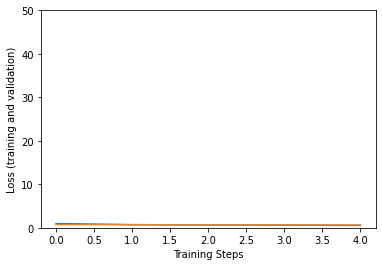

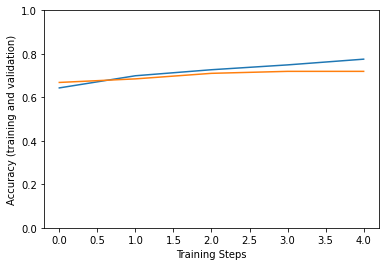

In [ ]:
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)


['Melanoma' 'Nevus' 'Seborrheic_Keratosis']


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 3)


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Nevus' 'Nevus' 'Seborrheic_Keratosis' 'Nevus' 'Nevus' 'Nevus' 'Nevus'
 'Melanoma' 'Nevus' 'Nevus' 'Nevus' 'Nevus' 'Nevus' 'Nevus' 'Nevus'
 'Nevus' 'Nevus' 'Nevus' 'Nevus' 'Nevus' 'Nevus' 'Nevus' 'Nevus' 'Nevus'
 'Nevus' 'Nevus' 'Nevus' 'Nevus' 'Seborrheic_Keratosis' 'Nevus'
 'Seborrheic_Keratosis' 'Nevus']


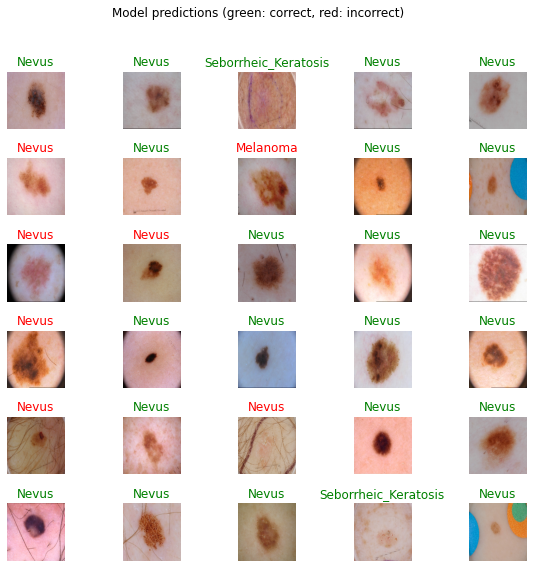

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")